In [11]:
from sympy import *
init_printing()

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [13]:
# Load dataset
file_path_korup_parken = "/Users/nicolaigarderhansen/Desktop/Bachelorprojekt/Data/Bygholm_K\u00f8rup_Parken_VNF_d\u00f8gn_1975-2023.csv"
korup_parken_df = pd.read_csv(file_path_korup_parken, decimal=",", encoding="ISO-8859-1", delimiter=";")

# Clean column names
korup_parken_df.columns = korup_parken_df.columns.str.strip()
korup_parken_df.columns = ["timestamp", "KarupBro", "BygholmPark"]

# Convert timestamp to datetime format
korup_parken_df["timestamp"] = pd.to_datetime(korup_parken_df["timestamp"], format="%d-%m-%Y")

# Drop the BygholmPark column
korup_parken_df = korup_parken_df.drop(columns=["BygholmPark"])

# Sort by timestamp
korup_parken_df = korup_parken_df.sort_values("timestamp").reset_index(drop=True)

# Ensure no missing values
korup_parken_df = korup_parken_df.dropna()

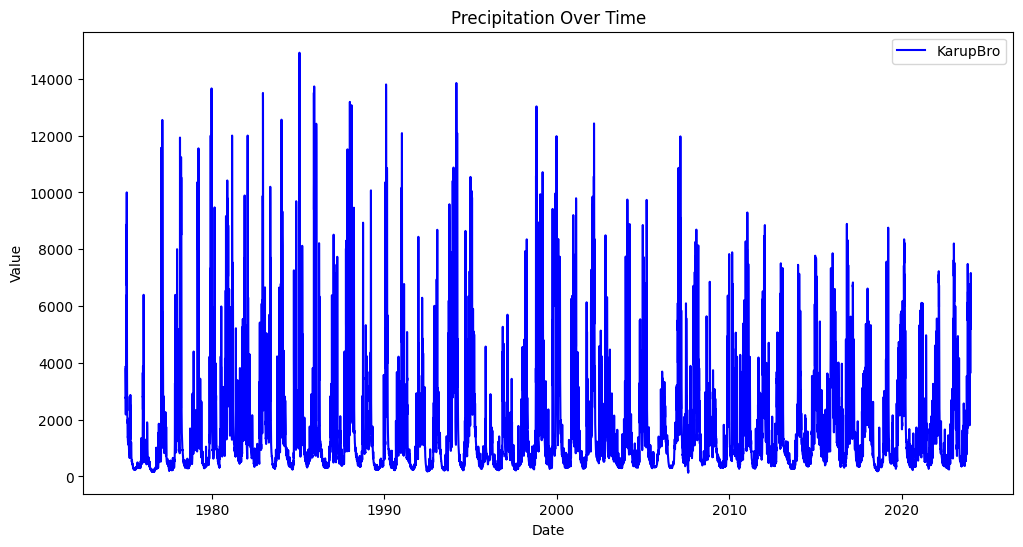

ADF Statistic: -14.063712329719836
p-value: 3.0246867605006225e-26
Critical Values:
   1%: -3.430715969421735
   5%: -2.86170174456077
   10%: -2.566856092394495
The data is likely stationary (reject null hypothesis).


In [14]:
# Plot the time series
def plot_time_series(df, column, title):
    plt.figure(figsize=(12, 6))
    plt.plot(df["timestamp"], df[column], label=column, color='blue')
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.title(title)
    plt.legend()
    plt.show()

plot_time_series(korup_parken_df, "KarupBro", "Precipitation Over Time")

# Perform Augmented Dickey-Fuller (ADF) test to check stationarity
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] < 0.05:
        print("The data is likely stationary (reject null hypothesis).")
    else:
        print("The data is likely non-stationary (fail to reject null hypothesis).")

adf_test(korup_parken_df["KarupBro"])

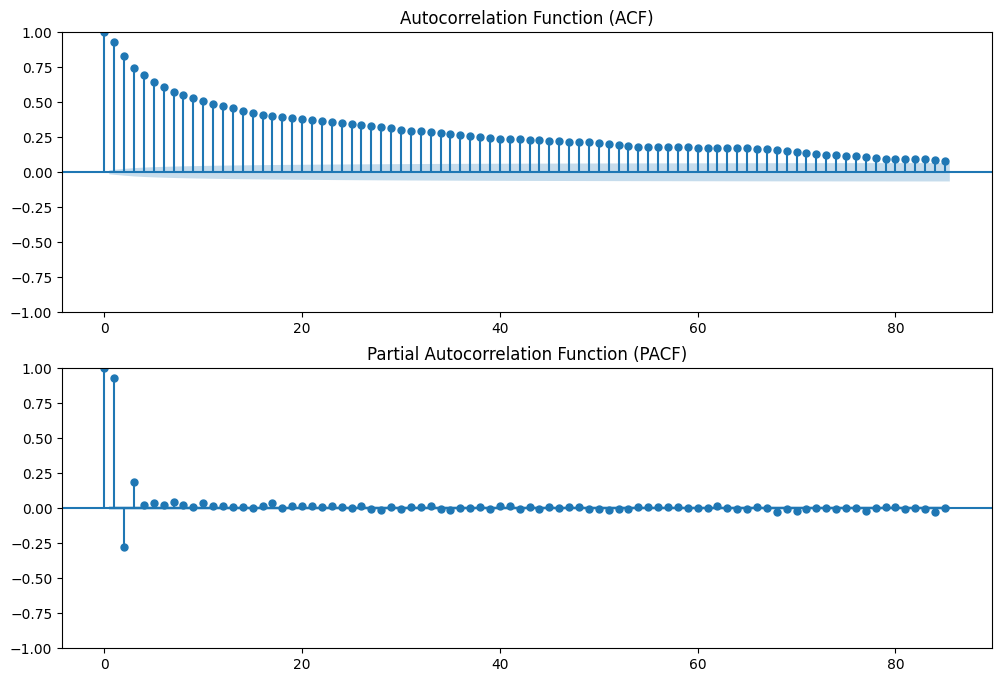

In [15]:
# Plot Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sm.graphics.tsa.plot_acf(korup_parken_df["KarupBro"], ax=ax[0], lags=85)
ax[0].set_title("Autocorrelation Function (ACF)")
sm.graphics.tsa.plot_pacf(korup_parken_df["KarupBro"], ax=ax[1], lags=85)
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()

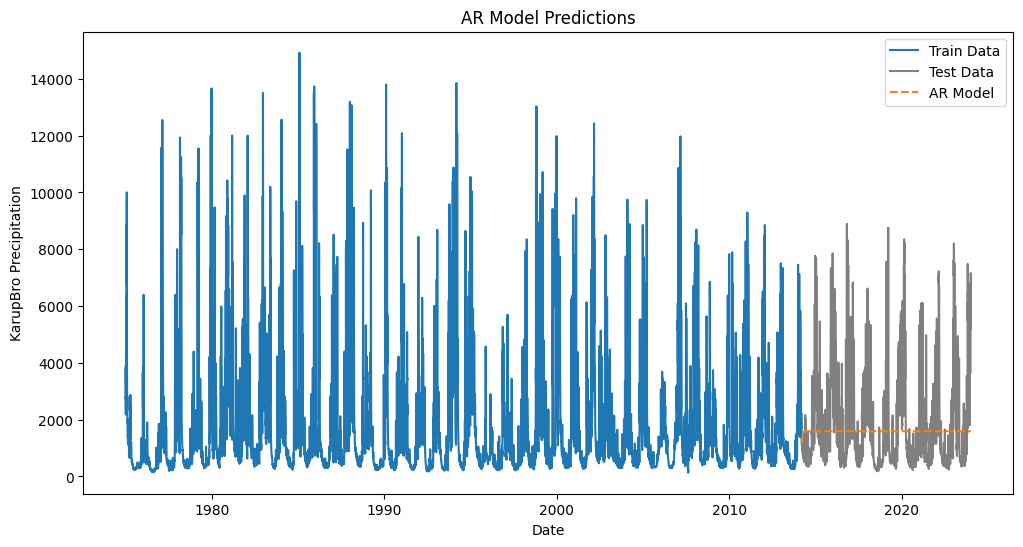

In [17]:
# Split train and test
train = korup_parken_df.iloc[:-int(len(korup_parken_df) * 0.2)]
test = korup_parken_df.iloc[-int(len(korup_parken_df) * 0.2):]

# --- Autoregression (AR) Model with 4 lags ---
model_ar = AutoReg(train["KarupBro"], lags=4).fit()
pred_ar = model_ar.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# --- Plot results ---
plt.figure(figsize=(12, 6))
plt.plot(train["timestamp"], train["KarupBro"], label="Train Data")
plt.plot(test["timestamp"], test["KarupBro"], label="Test Data", color='gray')
plt.plot(test["timestamp"], pred_ar, label="AR Model", linestyle='dashed')
plt.xlabel("Date")
plt.ylabel("KarupBro Precipitation")
plt.title("AR Model Predictions")
plt.legend()
plt.show()